In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from numpy.fft import fft

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["figure.figsize"] = (30, 20)

In [14]:
## process_file() takes a string with a path to the .csv
def process_file(pathname):
    res = pd.read_csv(pathname, sep = ',', header = 0, index_col = None, names = ['time', 'seconds', 'z', 'y', 'x'])
    return res

## butterworth() takes a dataframe with our accelerometer data and applies the Butterworth filter to it. 
## The columns of the DF is overwritten by the filtered values.
## Sources: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html 
##               https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def butterworth(df):
    nyquist_frequency = 0.5 * 50
    
    low = 0.5 / nyquist_frequency
    high = 3.0 / nyquist_frequency
    
    b, a = signal.butter(3, Wn=[low, high], btype='bandpass')

    df['x'] = signal.filtfilt(b, a, df['x'])
    df['y'] = signal.filtfilt(b, a, df['y'])
    df['z'] = signal.filtfilt(b, a, df['z'])

    return df

## fourier() takes a dataframe with our filtered accelerometer data and produces a new dataframe with x, y pairs.
## This produces the Fourier-transformed data. (I assume)
## Sources: https://stackoverflow.com/questions/66675657/fast-fourier-transform-for-an-accelerometer-in-python
def fourier(df):
    yf = np.abs(fft(df['x'] + df['y'] + df['z']))
    xf = np.linspace(0, 50, len(yf))

    return pd.DataFrame(zip(xf, yf), columns = ['x', 'y'])

## to_row() takes a Fourier-transformed dataframe and transposes its 'y' column into a row.
## This makes it possible to pass the transformed dataframe into an ML model.
def to_row(input, name):
    df = pd.DataFrame(input)
    df = df.T
    df.reset_index(drop = True, inplace = True)
    df.insert(loc = 0, column = 'Name', value = name)

    return df
    

In [15]:
# Processing .csv files, passing them through Butterworth filter, and Fourier transforming them

##### 5-MINUTE DATA

dlp_5min = butterworth(process_file('processed_data/dlp_5min.csv'))
drp_5min = butterworth(process_file('processed_data/drp_5min.csv'))
dlp5m_f = fourier(dlp_5min)
drp5m_f = fourier(drp_5min)

mrp_5min = butterworth(process_file('processed_data/mrp_5min.csv'))
mrp5m_f = fourier(mrp_5min)

slp_5min = butterworth(process_file('processed_data/slp_5min.csv'))
srp_5min = butterworth(process_file('processed_data/srp_5min.csv'))
slp5m_f = fourier(slp_5min)
srp5m_f = fourier(srp_5min)


# Butterworth Filter

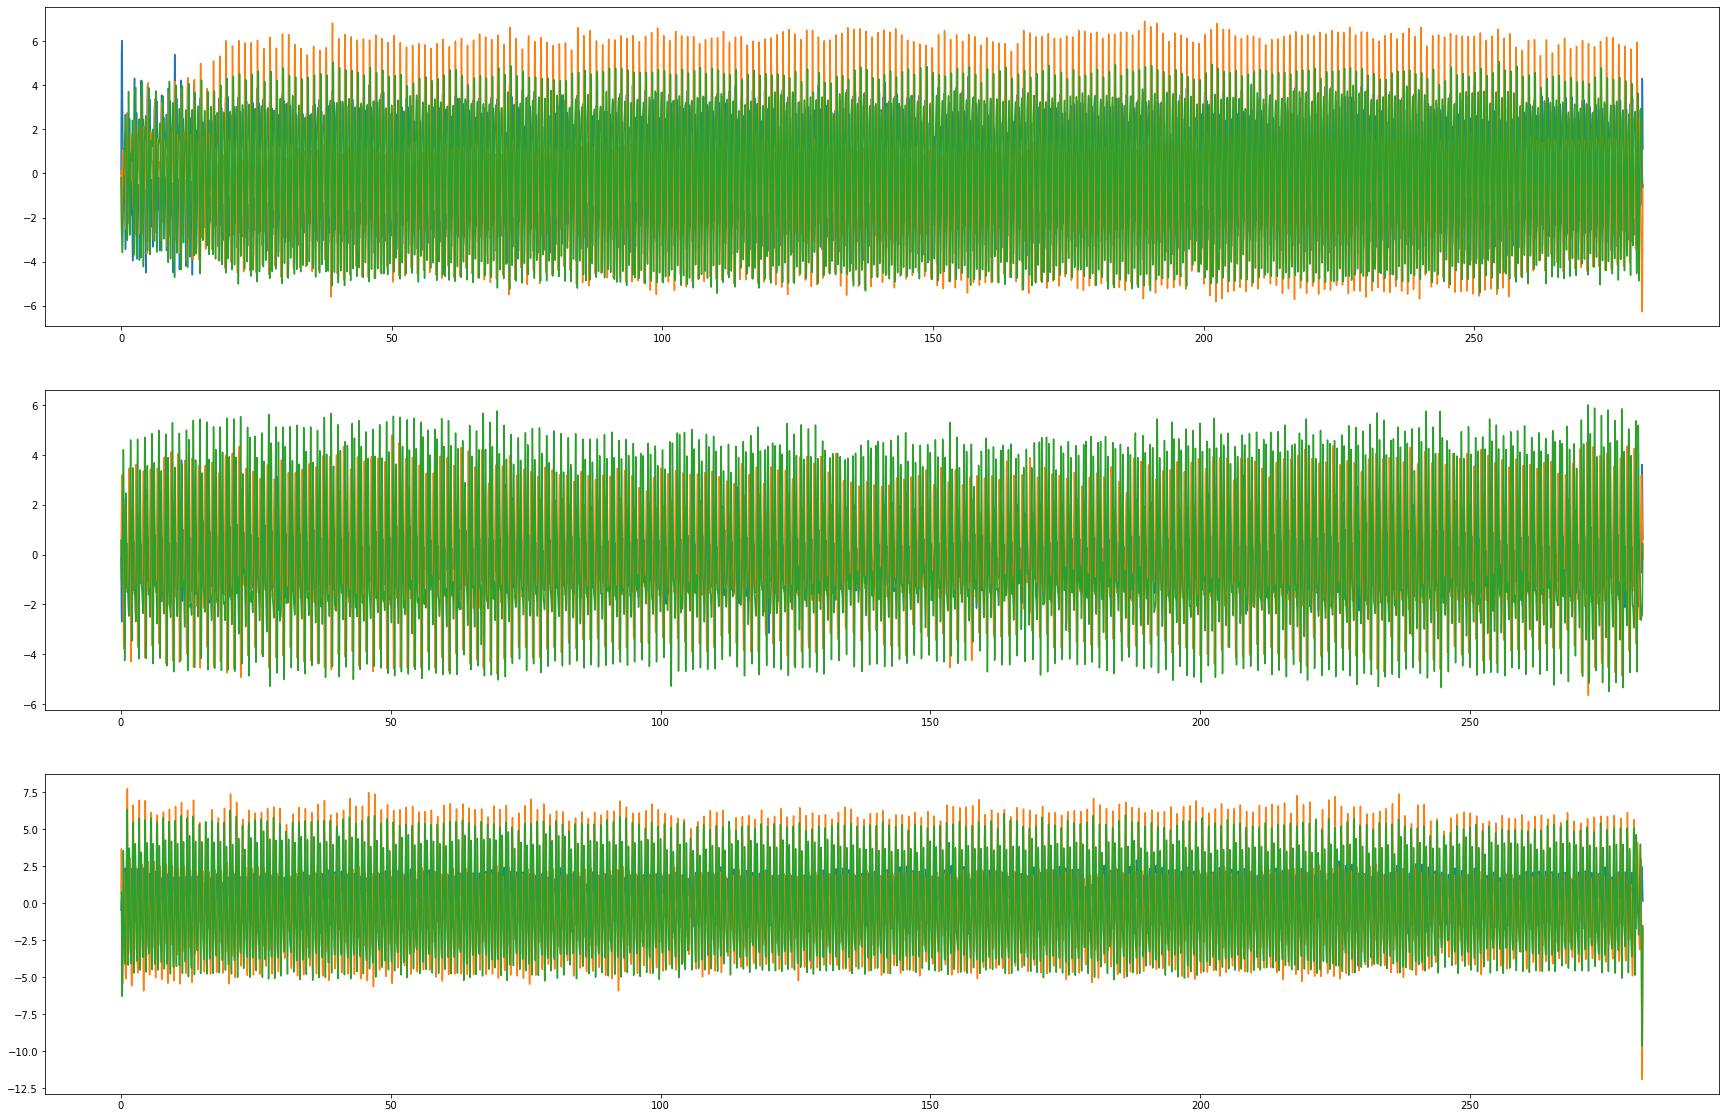

In [16]:
# Plotting Butterworth filtered data. Each line represents an axis.
fig, ax = plt.subplots(3)

# Diego
ax[0].plot(dlp_5min['seconds'], dlp_5min['x'])
ax[0].plot(dlp_5min['seconds'], dlp_5min['y'])
ax[0].plot(dlp_5min['seconds'], dlp_5min['z'])

# Matt
ax[1].plot(mrp_5min['seconds'], mrp_5min['x'])
ax[1].plot(mrp_5min['seconds'], mrp_5min['y'])
ax[1].plot(mrp_5min['seconds'], mrp_5min['z'])

# Sam
ax[2].plot(slp_5min['seconds'], slp_5min['x'])
ax[2].plot(slp_5min['seconds'], slp_5min['y'])
ax[2].plot(slp_5min['seconds'], slp_5min['z'])

# Fourier Transform

(0.0, 1.0)

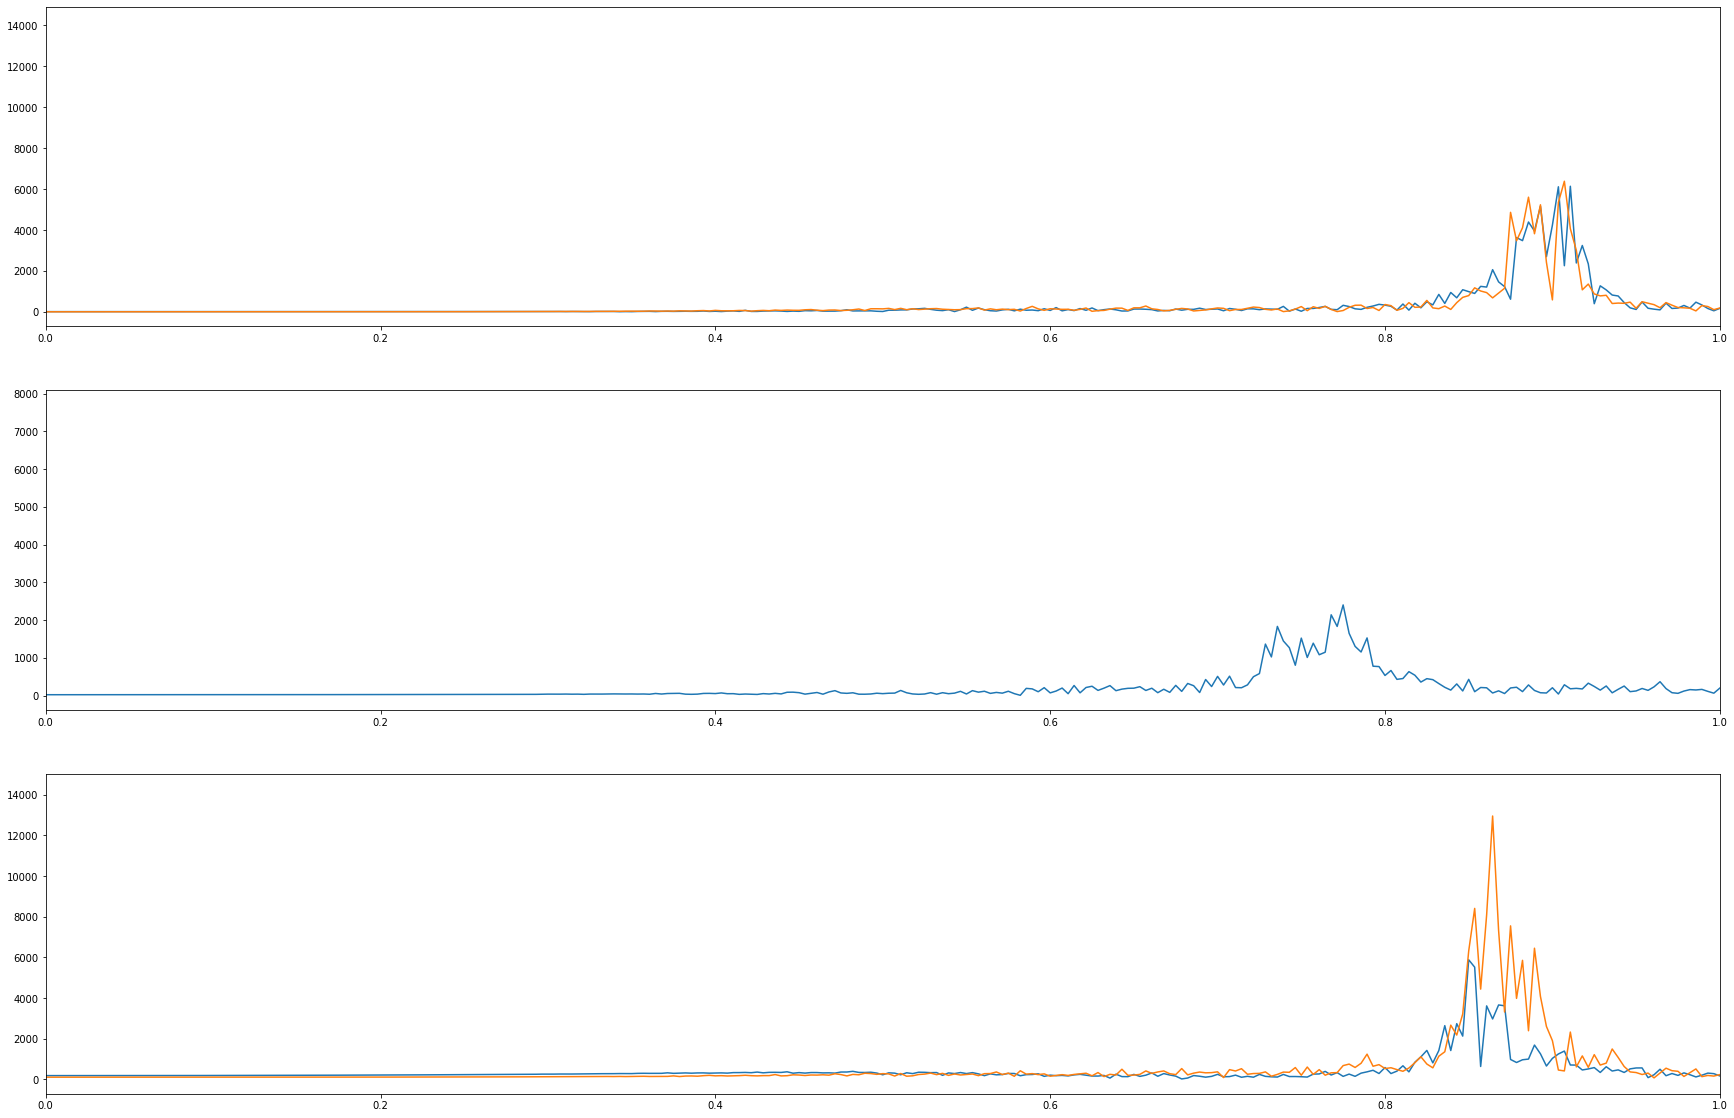

In [17]:
# Plotting Fourier transformed data. Each line represents a collection point (left pocket vs. right pocket).
fig, ax = plt.subplots(3)

# Diego 5min
ax[0].plot(dlp5m_f['x'], dlp5m_f['y'])
ax[0].plot(drp5m_f['x'], drp5m_f['y'])
ax[0].set_xlim(0, 1)

# Matt 5min
ax[1].plot(mrp5m_f['x'], mrp5m_f['y'])
ax[1].set_xlim(0, 1)

# Sidak 5min
ax[2].plot(slp5m_f['x'], slp5m_f['y'])
ax[2].plot(srp5m_f['x'], srp5m_f['y'])
ax[2].set_xlim(0, 1)

# Machine Learning

In [46]:
# Splitting the 5-minute dataset into 10 equal parts.
dlp_5min['name'] = 'diego'
drp_5min['name'] = 'diego'
mrp_5min['name'] = 'matt'
slp_5min['name'] = 'sam'
srp_5min['name'] = 'sam'

dlsplit = np.array_split(dlp_5min, 30)
drsplit = np.array_split(drp_5min, 30)
mrsplit = np.array_split(mrp_5min, 30)
slsplit = np.array_split(slp_5min, 30)
srsplit = np.array_split(srp_5min, 30)

tnames = []
tdata = []

for i in [dlsplit, drsplit, mrsplit, slsplit, srsplit]:
    for j in range(len(i) - 1):
        temp = i[j]

        if ((temp['name'] == 'diego').all()):
            tnames.append('diego')
        if ((temp['name'] == 'matt').all()):
            tnames.append('matt')
        if ((temp['name'] == 'sam').all()):
            tnames.append('sam')

        temp['combined'] = temp['x'] + temp['y'] + temp['z']
        tdata.append(np.asarray(temp['combined']))

training_data = pd.DataFrame(tnames)
training_data['joined'] = pd.Series(tdata, index = training_data.index)
training_data.rename(columns = {0 : 'name'}, inplace = True)
training_data = pd.concat([training_data['name'], training_data.pop('joined').apply(pd.Series)], axis=1).dropna(axis = 1)

## ML portion starts here

X = training_data.drop(columns = ['name'])
y = training_data['name']

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

bayes_model = make_pipeline(
    GaussianNB()
)

knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 8)
)

nn_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(solver = 'lbfgs', hidden_layer_sizes = (16,8,4), activation = 'logistic', max_iter=100000)
)

dt_model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(max_depth = 125)
)

rf_model = make_pipeline(
    RandomForestClassifier(n_estimators = 1500 , max_depth = 3, min_samples_leaf = 5)
)

print('bayes')
bayes_model.fit(X_train, y_train)
print(bayes_model.score(X_train, y_train))
print(bayes_model.score(X_valid, y_valid))
print('')
print('knn')
knn_model.fit(X_train, y_train)
print(knn_model.score(X_train, y_train))
print(knn_model.score(X_valid, y_valid))
print('')
print('neural net')
nn_model.fit(X_train, y_train)
print(nn_model.score(X_train, y_train))
print(nn_model.score(X_valid, y_valid))
print('')
print('decision tree')
dt_model.fit(X_train, y_train)
print(dt_model.score(X_train, y_train))
print(dt_model.score(X_valid, y_valid))
print('')
print('random forest')
rf_model.fit(X_train, y_train)
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_valid, y_valid))

bayes
0.7222222222222222
0.6216216216216216

knn
0.8888888888888888
0.7837837837837838

neural net
0.9537037037037037
0.5405405405405406

decision tree
1.0
0.5945945945945946

random forest
0.8611111111111112
0.6216216216216216


In [47]:
training_data

,name,0,1,2,3,4,5,6,7,8,...,456,457,458,459,460,461,462,463,464,465
0,diego,-0.095687,0.097069,0.266455,0.392098,0.461599,0.473078,0.434981,0.362756,0.273579,...,-1.905107,-1.891487,-1.789703,-1.577146,-1.239584,-0.777704,-0.210871,0.423377,1.074505,1.687736
1,diego,2.615939,2.874102,2.983082,2.949400,2.786658,2.511085,2.137668,1.677337,1.135688,...,0.669209,0.318044,-0.158457,-0.748347,-1.408425,-2.072338,-2.661630,-3.098239,-3.317334,-3.278712
2,diego,-2.430746,-1.704031,-0.871836,-0.021711,0.759843,1.396752,1.830636,2.025808,1.971626,...,-1.705277,-2.130954,-2.470286,-2.669210,-2.684886,-2.495302,-2.105653,-1.549457,-0.883935,-0.180962
3,diego,1.042528,1.441568,1.648736,1.654000,1.467995,1.117510,0.639103,0.072122,-0.547168,...,0.427464,1.077906,1.564437,1.844022,1.895849,1.721865,1.345346,0.807495,0.162099,-0.531431
4,diego,-1.843135,-2.380173,-2.810715,-3.134494,-3.362687,-3.510585,-3.589088,-3.597864,-3.523227,...,-1.904583,-2.599118,-3.226862,-3.772751,-4.222427,-4.558326,-4.757022,-4.789460,-4.625208,-4.240284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,sam,6.226042,6.040436,5.604778,5.032410,4.413350,3.803565,3.224233,2.666794,2.100221,...,-5.783968,-5.789551,-5.152689,-3.999695,-2.494836,-0.816296,0.860981,2.379043,3.611496,4.478842
141,sam,4.959033,5.086329,4.936368,4.602690,4.173733,3.717285,3.274002,2.857515,2.457946,...,-4.916059,-5.837328,-6.007249,-5.461248,-4.317136,-2.745613,-0.942722,0.890530,2.564905,3.921757
142,sam,4.854826,5.327962,5.378494,5.101955,4.623750,4.068561,3.536433,3.089257,2.747106,...,3.602618,0.930143,-1.659184,-3.899556,-5.559655,-6.479661,-6.596234,-5.947247,-4.656117,-2.904639
143,sam,-0.905039,1.123852,2.977932,4.489555,5.547941,6.111220,6.203916,5.900912,5.305052,...,8.371284,9.537020,10.294638,10.536668,10.182417,9.196040,7.601247,5.489647,3.020041,0.406791
